While a **simple momentum strategy** uses equal weighting for simplicity, this approach often does not perform well in the real life. Therefore, we will test the hypothesis that **weighting** should be based on rank: the higher the rank, the more **weight** a stock receives for a long position, and the lower the rank, the more **weight** it receives for a short position. We will use historical of top 1000 stocks data in the US to check this hypothesis.

In [32]:
# Import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Load the data
file_path = r"C:\Users\ADMIN\Documents\CF_LeHoangPhuc-22110160_TranLongNhat-22110142\lab01\top_1000_stock_2015_2025.csv"
df = pd.read_csv(file_path, parse_dates=["date"])
print(df.head())
print(df.columns)

        date ticker       open       high        low      close  adj_close  \
0 2015-01-02   AAPL  27.847500  27.860001  26.837500  27.332500  24.261047   
1 2015-01-02   ABBV  65.440002  66.400002  65.440002  65.889999  42.091419   
2 2015-01-02    ABT  45.250000  45.450001  44.639999  44.900002  36.418671   
3 2015-01-02   ADBE  72.699997  73.199997  71.889999  72.339996  72.339996   
4 2015-01-02    ADI  55.680000  56.250000  54.970001  55.540001  44.511143   

        volume  
0  212818400.0  
1    5086100.0  
2    3216600.0  
3    2349200.0  
4    1323200.0  
Index(['date', 'ticker', 'open', 'high', 'low', 'close', 'adj_close',
       'volume'],
      dtype='object')


In [34]:
# Resample to month-end prices
df = df.set_index("date")

agg_dict = {
    "open":"first",
    "high":"max",
    "low":"min",
    "close":"last",
    "adj_close":"last",
    "volume":"sum"
}

monthly = (
    df.groupby("ticker")
    .resample("ME")
    .agg(agg_dict)
    .reset_index()
)

print(monthly)

       ticker       date       open       high        low      close  \
0           A 2015-01-31  41.180000  41.310001  37.680000  37.770000   
1           A 2015-02-28  37.900002  42.490002  37.709999  42.209999   
2           A 2015-03-31  42.340000  42.740002  40.369999  41.549999   
3           A 2015-04-30  41.459999  43.590000  40.720001  41.369999   
4           A 2015-05-31  41.410000  42.930000  40.820000  41.189999   
...       ...        ...        ...        ...        ...        ...   
111679    ZWS 2025-05-31  34.299999  37.759998  33.880001  36.189999   
111680    ZWS 2025-06-30  35.939999  37.060001  35.060001  36.570000   
111681    ZWS 2025-07-31  36.279999  44.270000  35.730000  44.250000   
111682    ZWS 2025-08-31  43.439999  46.599998  43.250000  45.360001   
111683    ZWS 2025-09-30  44.619999  48.419998  44.509998  47.029999   

        adj_close      volume  
0       34.567509  53086600.0  
1       38.631046  52418300.0  
2       38.120682  44856400.0  
3      

In [35]:
# Caculate log-return
monthly["log_return"] = (
    np.log(monthly["adj_close"]) - 
    np.log(monthly.groupby("ticker")["adj_close"].shift(1))
)
monthly = monthly.dropna(subset=["log_return"])

# Shift log_return ahead 1 to avoid look ahead bias
monthly["lagged_return"] = monthly.groupby("ticker")["log_return"].shift(1)

print(monthly.head())

  ticker       date       open       high        low      close  adj_close  \
1      A 2015-02-28  37.900002  42.490002  37.709999  42.209999  38.631046   
2      A 2015-03-31  42.340000  42.740002  40.369999  41.549999  38.120682   
3      A 2015-04-30  41.459999  43.590000  40.720001  41.369999  37.955536   
4      A 2015-05-31  41.410000  42.930000  40.820000  41.189999  37.790375   
5      A 2015-06-30  41.430000  41.430000  38.480000  38.580002  35.484417   

       volume  log_return  lagged_return  
1  52418300.0    0.111142            NaN  
2  44856400.0   -0.013299       0.111142  
3  47256700.0   -0.004342      -0.013299  
4  44096800.0   -0.004361      -0.004342  
5  58978100.0   -0.062961      -0.004361  


In [40]:
# Weight momentum strategy
n = 100 # Choose how many stocks to long/short

monthly["rank"] = monthly.groupby('date')["lagged_return"].rank(method="first", ascending=False)
monthly["position"] = 0
monthly.loc[monthly["rank"] <= n, "position"] = 1 # long
monthly.loc[monthly["rank"] > monthly.groupby("date")["rank"].transform("max") - n, "position"] = -1

def rank_weighted(df):
    # Separate long and short
    long = df[df["position"] == 1].copy()
    short = df[df["position"] == -1].copy()
    
    # Weight proportional to rank: higher rank = higher weight
    if not long.empty:
        long["weight"] = long["rank"] / long["rank"].sum()
    if not short.empty:
        # For shorts, invert rank so bottom ranks get higher weight
        short["weight"] = (short["rank"].max() - short["rank"] + 1) / (short["rank"].max() - short["rank"] + 1).sum()
    
    return pd.concat([long, short])

monthly = monthly.groupby("date", group_keys=False).apply(rank_weighted)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11552\3535897839.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly = monthly.groupby("date", group_keys=False).apply(rank_weighted)


In [41]:
# Compute rank-weighted portfolio return

monthly["weighted_return"] = monthly["log_return"] * monthly["weight"] * monthly["position"]
portfolio_returns = monthly.groupby("date")["weighted_return"].sum()

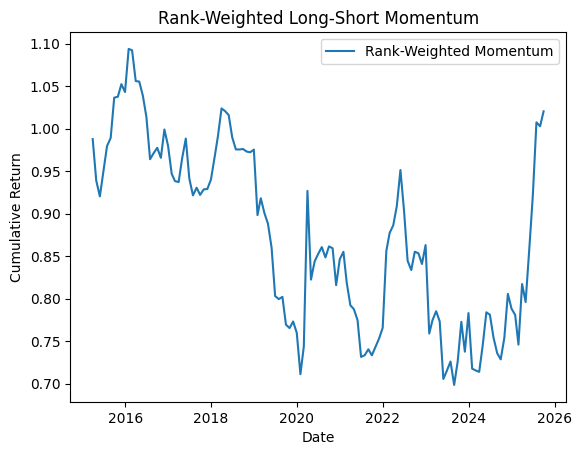

In [42]:
cum_return = np.exp(portfolio_returns.cumsum())

plt.plot(cum_return, label="Rank-Weighted Momentum")
plt.title("Rank-Weighted Long-Short Momentum")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.show()

In [43]:
# Statistics
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()
N = len(portfolio_returns)

# t-statistic
t_stat = mu / (sigma / np.sqrt(N))

# two-tailed p-value using scipy
from scipy import stats
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=N-1))

print(f"Mean monthly return: {mu:.4f}")
print(f"Std dev: {sigma:.4f}")
print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

Mean monthly return: 0.0002
Std dev: 0.0434
t-statistic: 0.04
p-value: 0.9672
